# Problem Set 1: Edges and Lines
---
## Setup

In [18]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [20]:
# Change to True if Jupyter Widgets extension is installed
IS_INTERACTIVE = True
# Turn widgets on-off
if IS_INTERACTIVE:
    from ipywidgets import interact
else:
    def interact(**kwargs):
        def decorator(f):
            return f()
        return decorator

---
## 1. Edge Operator

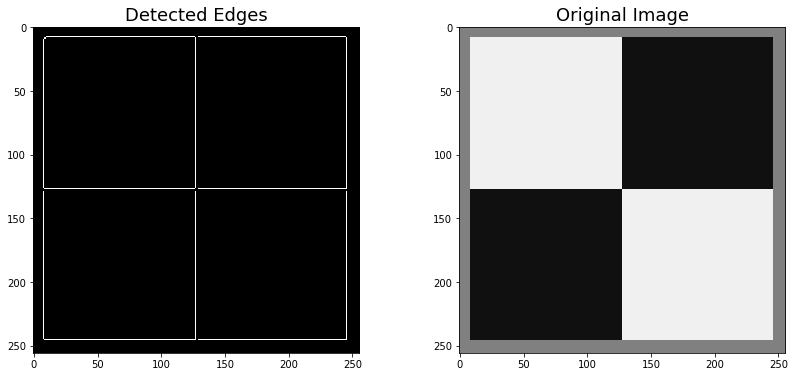

In [21]:
# Load image
img1 = cv2.imread('ps1-input0.png')
# OpenCV BGR to RGB
img1 = img1[:,:,::-1]
# Edge Detection
img1_edges = cv2.Canny(img1, 100, 200)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Detected Edges')
ax[0].imshow(img1_edges)
ax[1].set_title('Original Image')
ax[1].imshow(img1);

---
## 2. Hough Line Detector

In [45]:
def rho_range(img):
    rho_min = -img.shape[1]
    rho_max = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    return rho_min, rho_max

def houghlines_accum(img, rho_res=1.0, theta_res=np.pi/180):
    num_theta = int(round(np.pi / theta_res))
    rho_min, rho_max = rho_range(img)
    num_rho = int(round((rho_max-rho_min) / rho_res)) + 1
    accum = np.zeros((num_rho, num_theta))
    for y, row in enumerate(img):
        for x, val in enumerate(row):
            if val > 0:
                for theta_ix in range(num_theta):
                    theta = theta_ix * theta_res
                    rho = x*np.cos(theta) + y*np.sin(theta)
                    rho_ix = int(round((rho-rho_min) / rho_res))
                    accum[rho_ix, theta_ix] += 1
    return accum

def extract_lines(accum, rho_min, rho_res=1.0, theta_res=np.pi/180, thresh=100):
    lines = []
    rows, cols = accum.shape
    for rho_ix in range(1, rows-1):
        for theta_ix in range(cols):
            if accum[rho_ix, theta_ix] > thresh:
                rho = rho_min + rho_ix*rho_res
                if theta_ix == 0:
                    rho_left = int(round((-rho-rho_min) / rho_res))
                    left = accum[rho_left, -1]
                    right = accum[rho_ix, theta_ix+1]
                elif theta_ix == cols-1:
                    rho_right = int(round((-rho-rho_min) / rho_res))
                    left = accum[rho_ix, theta_ix-1]
                    right = accum[rho_right, 0]
                else:
                    left = accum[rho_ix, theta_ix-1]
                    right = accum[rho_ix, theta_ix+1]
                    
                if accum[rho_ix, theta_ix] > accum[rho_ix-1, theta_ix] and \
                accum[rho_ix, theta_ix] >= accum[rho_ix+1, theta_ix] and \
                accum[rho_ix, theta_ix] > left and \
                accum[rho_ix, theta_ix] >= right:
                    rho = rho_min + rho_ix*rho_res
                    theta = theta_ix*theta_res
                    lines.append((rho, theta))
    return lines   

def get_line_points(rho, theta, xrange, yrange=0):
    if np.sin(theta):
        fx = (rho - xrange*np.cos(theta)) / np.sin(theta)
        return xrange, fx
    else:
        fy = (rho - yrange*np.sin(theta)) / np.cos(theta)
        return fy, yrange
    
def plot_hough_result(img, lines, accum):
    fig, ax = plt.subplots(1, 2)
    # Get rho range
    rho_min, rho_max = rho_range(img)
    # Lines
    ax[0].imshow(img)
    ax[0].set_title('Detected Lines')
    # Fix x,y axes
    ax[0].set_ylim(img.shape[0], 0)
    ax[0].set_xlim(0, img.shape[1])
    xrange = range(img.shape[1])
    yrange = range(img.shape[0])
    # Plot each line
    for rho, theta in lines:
        ax[0].plot(*get_line_points(rho, theta, xrange, yrange), 'g')
    # Accumulator
    im = ax[1].imshow(accum, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
    # Fix x,y axes
    ax[1].set_ylim(rho_min, rho_max)
    ax[1].set_xlim(0, np.pi)
    if lines:
        rho, theta = zip(*lines)
        ax[1].scatter(theta, rho, s=80, facecolors='none', edgecolors='r')
    ax[1].set_title('Accumulator')
    # Create colorbar
    plt.colorbar(im)

In [39]:
@interact(rho_res=(1, 10))
def img1_hough_accum(rho_res=1):
    # Hacks
    global accum
    global rho_res_img1
    # Find lines
    rho_res_img1 = rho_res
    accum = houghlines_accum(img1_edges, rho_res=rho_res)
    # Get rho range
    rho_min, rho_max = rho_range(img1_edges)
    # Plot accumulator
    plt.figure(figsize=(7, 6))
    im = plt.imshow(accum, aspect='auto', origin='lower', extent=[0, 180, rho_min, rho_max])
    plt.title('Accumulator')
    # Create colorbar
    plt.colorbar(im)

interactive(children=(IntSlider(value=1, description='rho_res', max=10, min=1), Output()), _dom_classes=('widg…

In [46]:
@interact(thresh=(100, 500))
def img1_hough(thresh=200):
    # Get rho range
    rho_min, _ = rho_range(img1_edges)
    # Get lines from accumulator matrix
    lines = extract_lines(accum, rho_min, rho_res=rho_res_img1, thresh=thresh)
    # Plot
    plot_hough_result(img1, lines, accum)

interactive(children=(IntSlider(value=200, description='thresh', max=500, min=100), Output()), _dom_classes=('…

---
## 3. Edge Detection with Noise

In [25]:
# Load Noisy image
img1n = cv2.imread('ps1-input0-noise.png')
# OpenCV BGR to RGB
img1n = img1n[:,:,::-1]

### a. Gaussian Filter

In [26]:
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img1_gaussian_blur(ksize=13, sigma=4.2):
    global img1n_blur
    # Add blur
    img1n_blur = cv2.GaussianBlur(img1n, (ksize, ksize), sigma)
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1n_blur)
    ax[0].set_title('Smoothed Image')
    ax[1].imshow(img1n)
    ax[1].set_title('Original Image')

interactive(children=(IntSlider(value=13, description='ksize', max=25, min=1, step=2), FloatSlider(value=4.2, …

### b. Edge Operator

In [27]:
@interact(thresh1_low=(0,255), thresh1_high=(0,255))
def img1_canny(thresh1_low=50, thresh1_high=65):
    global img1n_blur_edges
    # Canny edge operator
    img1n_blur_edges = cv2.Canny(img1n_blur, thresh1_low, thresh1_high)
    img1n_edges = cv2.Canny(img1n, 50, 65)
    # Plot
    fig, ax = plt.subplots(1, 2)
    fig.suptitle('Edge Detection')
    ax[0].imshow(img1n_blur_edges)
    ax[0].set_title('Smoothed Image')
    ax[1].imshow(img1n_edges)
    ax[1].set_title('Original Image')

interactive(children=(IntSlider(value=50, description='thresh1_low', max=255), IntSlider(value=65, description…

### c. Hough Line detection

In [47]:
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5))
def img1n_hough_accum(rho_res=4.0, theta_res_deg=3.0):
    # Hacks
    global accum, rho_res_img1n, theta_res_img1n
    # Find lines
    rho_res_img1n = rho_res
    theta_res_img1n = theta_res_deg * np.pi/180
    accum = houghlines_accum(img1n_blur_edges, rho_res=rho_res_img1n, theta_res=theta_res_img1n)
    # Get rho range
    rho_min, rho_max = rho_range(img1n_blur_edges)
    # Plot accumulator
    plt.figure(figsize=(7, 6))
    im = plt.imshow(accum, aspect='auto', origin='lower', extent=[0, 180, rho_min, rho_max])
    plt.title('Accumulator')
    # Create colorbar
    plt.colorbar(im)

interactive(children=(IntSlider(value=4, description='rho_res', max=10, min=1), FloatSlider(value=3.0, descrip…

In [48]:
@interact(thresh=(50, 400))
def img1n_hough(thresh=170):
    # Get rho range
    rho_min, _ = rho_range(img1n_blur_edges)
    # Get lines from accumulator matrix
    lines = extract_lines(accum, rho_min, rho_res=rho_res_img1n, theta_res=theta_res_img1n, thresh=thresh)
    # Plot
    plot_hough_result(img1n, lines, accum)

interactive(children=(IntSlider(value=170, description='thresh', max=400, min=50), Output()), _dom_classes=('w…

---
## 4. Edge Detection: Second Image

In [30]:
# Load Noisy image
img2 = cv2.imread('ps1-input1.jpg')
# OpenCV BGR to RGB
img2 = img2[:,:,::-1]

### a. Gaussian Filter

In [31]:
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img2_gaussian_blur(ksize=11, sigma=3.0):
    global img2_blur
    # Add blur
    img2_blur = cv2.GaussianBlur(img2, (ksize, ksize), sigma)
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img2_blur)
    ax[0].set_title('Smoothed Image')
    ax[1].imshow(img2)
    ax[1].set_title('Original Image')

interactive(children=(IntSlider(value=11, description='ksize', max=25, min=1, step=2), FloatSlider(value=3.0, …

### b. Edge Operator

In [32]:
@interact(thresh1_low=(0,255), thresh1_high=(0,255))
def img2_canny(thresh1_low=50, thresh1_high=100):
    global img2_edges
    # Canny edge operator
    img2_edges = cv2.Canny(img2_blur, thresh1_low, thresh1_high)
    # Plot
    plt.imshow(img2_edges)

interactive(children=(IntSlider(value=50, description='thresh1_low', max=255), IntSlider(value=100, descriptio…

### c. Hough Line detection

In [33]:
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5))
def img2_hough_accum(rho_res=1.0, theta_res_deg=3.0):
    # Hacks
    global accum, rho_res_img2, theta_res_img2
    # Find lines
    rho_res_img2 = rho_res
    theta_res_img2 = theta_res_deg * np.pi/180
    accum = houghlines_accum(img2_edges, rho_res=rho_res_img2, theta_res=theta_res_img2)
    # Get rho range
    rho_min, rho_max = rho_range(img2_edges)
    # Plot accumulator
    plt.figure(figsize=(7, 6))
    im = plt.imshow(accum, aspect='auto', origin='lower', extent=[0, 180, rho_min, rho_max])
    plt.title('Accumulator')
    # Create colorbar
    plt.colorbar(im)

interactive(children=(IntSlider(value=1, description='rho_res', max=10, min=1), FloatSlider(value=3.0, descrip…

In [34]:
@interact(thresh=(50, 200))
def img1n_hough(thresh=80):
    # Get rho range
    rho_min, _ = rho_range(img2_edges)
    # Get lines from accumulator matrix
    lines = extract_lines(accum, rho_min, rho_res=rho_res_img2, theta_res=theta_res_img2, thresh=thresh)
    # Plot
    plot_hough_result(img2, lines, accum)

interactive(children=(IntSlider(value=80, description='thresh', max=200, min=50), Output()), _dom_classes=('wi…

---
## 5. Hough Circle Detection

In [ ]:
def xy_range(img, r_max):
    x_min = -r_max
    x_max = img.shape[1] + r_max
    y_min = -r_max
    y_max = img.shape[0] + r_max
    return x_min, x_max, y_min, y_max

def houghcircles_accum(img, r_min, r_max, res=1.0, r_res=1.0):
    x_min, x_max, y_min, y_max = xy_range(img, r_max)
    num_x = int(round((x_max-x_min) / res))
    num_y = int(round((y_max-y_min) / res))
    num_r = int(round((r_max-r_min) / r_res))
    accum = np.zeros((num_y, num_x, num_r))
    for y, row in enumerate(img):
        for x, val in enumerate(row):
            if val > 0:
                for r_ix in range(num_r):
                    r = r_min + r_ix*r_res
                    for theta in np.arange(0, 2*np.pi, np.pi/180):
                        x_center = x + r*np.cos(theta)
                        y_center = y + r*np.sin(theta)
                        
                        x_ix = int(round((x_center-x_min) / res))
                        y_ix = int(round((y_center-y_min) / res))
                        
                        accum[y_ix, x_ix, r_ix] += 1
    return accum

def extract_circles(accum, xy_min, r_min, res=1.0, r_res=1.0, thresh=100):
    circles = []
    num_x, num_y, num_r = accum.shape
    for x_ix in range(1, num_x-1):
        for y_ix in range(1, num_y-1):
            for r_ix in range(1, num_r-1):
                if accum[x_ix, y_ix, r_ix] > thresh and \
                accum[x_ix, y_ix, r_ix] > accum[x_ix-1, y_ix, r_ix] and \
                accum[x_ix, y_ix, r_ix] > accum[x_ix+1, y_ix, r_ix] and \
                accum[x_ix, y_ix, r_ix] > accum[x_ix, y_ix-1, r_ix] and \
                accum[x_ix, y_ix, r_ix] > accum[x_ix, y_ix+1, r_ix] and \
                accum[x_ix, y_ix, r_ix] > accum[x_ix, y_ix, r_ix-1] and \
                accum[x_ix, y_ix, r_ix] > accum[x_ix, y_ix, r_ix+1]:
                    x = xy_min + x_ix*res
                    y = xy_min + y_ix*res
                    r = r_min + r_ix*r_res
                    circles.append((x, y, r))
    return circles

def plot_accum(ax, accum):
    # Get x, y range
    x_min, x_max, y_min, y_max = xy_range(img, r_max)
    # Accumulator
    im = ax[1].imshow(accum[:, :, r_ix], aspect='auto', origin='lower', extent=[x_min, x_max, y_min, y_max])
    # Fix x,y axes
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(y_min, y_max)
    if circles:
        x, y, r = zip(*circles)
        r_ix = int(round((r-r_min) / r_res))
        if r_ix == r_ix_slice:
            ax[1].scatter(x, y, s=80, facecolors='none', edgecolors='r')
    ax[1].set_title('Accumulator')
    # Create colorbar
    plt.colorbar(im)
    
def plot_hough_result(img, circles, accum, r_ix_slice, r_min, r_max, r_res=1.0):
    fig, ax = plt.subplots(1, 2)
    # Circles
    ax[0].imshow(img)
    ax[0].set_title('Detected Circles')
    # Fix x,y axes
    ax[0].set_ylim(img.shape[0], 0)
    ax[0].set_xlim(0, img.shape[1])
    # Plot each circle
    for x, y, r in circles:
        ax[0].plot((x, y), r)
    # Get x, y range
    x_min, x_max, y_min, y_max = xy_range(img, r_max)
    # Accumulator
    im = ax[1].imshow(accum[:, :, r_ix], aspect='auto', origin='lower', extent=[x_min, x_max, y_min, y_max])
    # Fix x,y axes
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(y_min, y_max)
    if circles:
        x, y, r = zip(*circles)
        r_ix = int(round((r-r_min) / r_res))
        if r_ix == r_ix_slice:
            ax[1].scatter(x, y, s=80, facecolors='none', edgecolors='r')
    ax[1].set_title('Accumulator')
    # Create colorbar
    plt.colorbar(im)

In [ ]:
r_min = 10.0
r_max = 50.0
houghcircles(img2_edges, r_min, r_max)

---
## 6. Clutter Image

### a. Line Detection

### b. Problems

### c. Finding boundaries of pen

---
## 7. Clutter Image: Circles
### a. Hough circle detector

### b. False Alarms

---
## 8. Distorted Image

### a. Line and Circle Detection

### b. Problems

### c. Fixing Circle problem